In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, load_val_dataset

torch.manual_seed(1234)

lr = 1e-4
EPS = 1e-10
T=5
device = 'cuda:0'

In [2]:
def train_instance(model, optimizer, data, n_ants):
    model.train()
    sum_loss = 0.0
    count = 0
    for pyg_data, distances in data:
        heu_vec = model(pyg_data)
        heu_mat = model.reshape(pyg_data, heu_vec) + EPS
        
        aco = ACO(
            n_ants=n_ants,
            heuristic=heu_mat,
            distances=distances,
            device=device
        )
    
        costs, log_probs = aco.sample()
        baseline = costs.mean()
        reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
        sum_loss += reinforce_loss
        count += 1

    sum_loss = sum_loss/count
    optimizer.zero_grad()
    sum_loss.backward()
    torch.nn.utils.clip_grad_norm_(parameters = model.parameters(), max_norm = 1.0, norm_type = 2)
    optimizer.step()

def infer_instance(model, pyg_data, distances, n_ants):
    model.eval()
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat,
        distances=distances,
        device=device,
        two_opt=True,
        )
    costs, log_probs = aco.sample()
    aco.run(n_iterations=T, inference = True)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = aco.lowest_cost
    return baseline.item(), best_sample_cost.item(), best_aco_cost.item()

In [3]:
def generate_traindata(count, n_node, k_sparse):
    for _ in range(count):
        instance = torch.rand(size=(n_node, 2), device=device)
        yield gen_pyg_data(instance, k_sparse=k_sparse, start_node=0)

def train_epoch(n_node,
                n_ants, 
                k_sparse, 
                epoch, 
                steps_per_epoch, 
                net, 
                optimizer,
                batch_size = 1,
                ):
    for _ in range(steps_per_epoch):
        train_instance(net, optimizer, generate_traindata(batch_size, n_node, k_sparse), n_ants)


@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    
    for data, distances in val_dataset:
        bl, sample_best, aco_best = infer_instance(net, data, distances, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    
    n_val = len(val_dataset)
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    
    return avg_bl, avg_sample_best, avg_aco_best

In [6]:
def train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size = 3, test_size = None):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    val_list = load_val_dataset(n_node, k_sparse, device, start_node=0)
    if test_size is not None:
        val_list = val_list[:test_size]
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_ants, -1, net, val_list, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net, optimizer, batch_size=batch_size)
        sum_time += time.time() - start
        avg_bl, avg_sample_best, avg_aco_best = validation(n_ants, epoch, net, val_list, animator)
        val_results.append((avg_bl, avg_sample_best, avg_aco_best))
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
        
    torch.save(net.state_dict(), f'../pretrained/tsp_2opt/tsp{n_node}.pt')

Learn heuristic for TSP20: 

total training duration: 178.28890919685364
epoch -1: (7.411573076248169, 6.2423345518112185, 3.807492878437042)
epoch 0: (7.375101370811462, 6.1680801439285275, 3.807492878437042)
epoch 1: (7.320790243148804, 6.156523818969727, 3.807492883205414)
epoch 2: (7.2341440534591674, 5.9977428293228146, 3.807492878437042)
epoch 3: (7.072773699760437, 5.921426148414612, 3.807492878437042)
epoch 4: (6.88165253162384, 5.677041988372803, 3.807492878437042)
epoch 5: (6.690441846847534, 5.570305500030518, 3.807492883205414)
epoch 6: (6.535217843055725, 5.4287052774429325, 3.807492880821228)
epoch 7: (6.332748055458069, 5.245918474197388, 3.807492878437042)
epoch 8: (6.156256284713745, 5.123546457290649, 3.8074928855895998)
epoch 9: (5.981001667976379, 5.015390563011169, 3.807492880821228)
epoch 10: (5.758944458961487, 4.793066358566284, 3.807492880821228)
epoch 11: (5.583747129440308, 4.665733830928803, 3.807492880821228)
epoch 12: (5.457667880058288, 4.546012997627258, 3.807492880821228)
epoch 13:

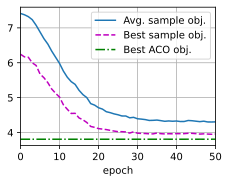

In [6]:
n_node, n_ants = 20, 20
k_sparse = 10
steps_per_epoch = 16
epochs = 50
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size=10)

Learn heuristic for TSP100: 

total training duration: 640.7841293811798
epoch -1: (21.385107822418213, 19.583151588439943, 7.938544363975525)
epoch 0: (21.22277276992798, 19.397976608276366, 7.926451964378357)
epoch 1: (21.08473171234131, 19.255872821807863, 7.935273785591125)
epoch 2: (20.81881031036377, 19.0194602394104, 7.927022156715393)
epoch 3: (20.44328025817871, 18.670514221191407, 7.9182452297210695)
epoch 4: (19.98427661895752, 18.196033744812013, 7.936225872039795)
epoch 5: (19.473313274383546, 17.67691457748413, 7.912812418937683)
epoch 6: (18.9283065032959, 17.190061845779418, 7.914894371032715)
epoch 7: (18.36454502105713, 16.60062336921692, 7.908234753608704)
epoch 8: (17.77555763244629, 16.124102268218994, 7.91530590057373)
epoch 9: (17.220776138305663, 15.42322699546814, 7.901759881973266)
epoch 10: (16.729412069320677, 14.99360652923584, 7.909865274429321)
epoch 11: (16.128285484313963, 14.44012228012085, 7.904294381141662)
epoch 12: (15.73945297241211, 14.138480157852173, 7.910234065055847)
epoc

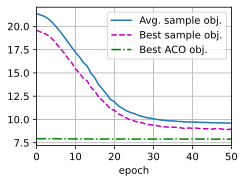

In [7]:
n_node = 100
n_ants = 20
k_sparse = 20
steps_per_epoch = 16
epochs = 50
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size=10)

Learn heuristic for TSP500: 

total training duration: 1992.632440328598
epoch -1: (69.0007308959961, 66.23641548156738, 38.408597755432126)
epoch 0: (68.51552925109863, 65.73895721435547, 38.040616798400876)
epoch 1: (67.67527046203614, 64.6518539428711, 37.62023220062256)
epoch 2: (66.62187805175782, 64.0488842010498, 36.866146850585935)
epoch 3: (64.85092067718506, 61.896494483947755, 35.62507514953613)
epoch 4: (62.94474639892578, 60.27016639709473, 34.27689743041992)
epoch 5: (60.352437019348145, 57.5649600982666, 32.81786479949951)
epoch 6: (57.63456554412842, 54.90091609954834, 31.202138805389403)
epoch 7: (55.473886489868164, 52.76001739501953, 29.931941413879393)
epoch 8: (52.76703853607178, 50.20205287933349, 28.374661350250243)
epoch 9: (50.65626220703125, 48.089202880859375, 27.235149765014647)
epoch 10: (48.327008438110354, 45.657229042053224, 26.16490936279297)
epoch 11: (47.08227424621582, 44.48589458465576, 25.534514141082763)
epoch 12: (44.40970039367676, 41.994136047363284, 24.23297119140625)
epoc

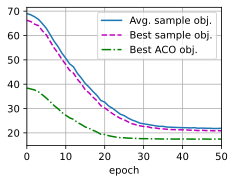

In [7]:
n_node = 500
n_ants = 20
k_sparse = 50
steps_per_epoch = 16
epochs = 50
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size = 5, test_size=20)